In [56]:
# Just if you want to obtain the data directly from Kaggle use this cell
import kagglehub
 # Download latest version
path = kagglehub.dataset_download("dhoogla/cic-evasive-pdfmal2022")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\34609\.cache\kagglehub\datasets\dhoogla\cic-evasive-pdfmal2022\versions\2


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pyarrow.parquet as pq 


In [58]:
path = 'PDFMalware2022.parquet'
parquet_file = pq.ParquetFile(path)

print(parquet_file.schema)

print("Número de filas:", parquet_file.metadata.num_rows)
print("Número de columnas:", parquet_file.metadata.num_columns)

required group field_id=-1 schema {
  optional binary field_id=-1 FileName (String);
  optional float field_id=-1 PdfSize;
  optional float field_id=-1 MetadataSize;
  optional float field_id=-1 Pages;
  optional float field_id=-1 XrefLength;
  optional float field_id=-1 TitleCharacters;
  optional float field_id=-1 isEncrypted;
  optional float field_id=-1 EmbeddedFiles;
  optional binary field_id=-1 Images (String);
  optional binary field_id=-1 Text (String);
  optional binary field_id=-1 Header (String);
  optional binary field_id=-1 Obj (String);
  optional binary field_id=-1 Endobj (String);
  optional float field_id=-1 Stream;
  optional binary field_id=-1 Endstream (String);
  optional binary field_id=-1 Xref (String);
  optional float field_id=-1 Trailer;
  optional binary field_id=-1 StartXref (String);
  optional binary field_id=-1 PageNo (String);
  optional float field_id=-1 Encrypt;
  optional float field_id=-1 ObjStm;
  optional binary field_id=-1 JS (String);
  optional

In [59]:
df = pd.read_parquet(path)
df.head()

,FileName,PdfSize,MetadataSize,Pages,XrefLength,TitleCharacters,isEncrypted,EmbeddedFiles,Images,Text,...,AA,OpenAction,Acroform,JBIG2Decode,RichMedia,Launch,EmbeddedFile,XFA,Colors,Class
0,aedaf3c5428a2e3ba600c44b96ad78dfdf8ed76e7df129...,8.0,180.0,1.0,11.0,0.0,0.0,0.0,0,No,...,0,1,0,0,0,0,0,0,0.0,Malicious
1,fe767fb2584a10c010626263ea950643ac25f6ca24628f...,15.0,224.0,0.0,20.0,7.0,0.0,0.0,0,No,...,0,0,1,0,0,0,8,1,0.0,Malicious
2,544c5223ee301affad514b6fa585b3191625aba0a7222b...,4.0,468.0,2.0,13.0,16.0,0.0,0.0,0,Yes,...,0,1,0,0,0,0,0,0,0.0,Malicious
3,669772e626deccb9cfb7eb6a61e13d248d0ea08f1abe15...,17.0,250.0,1.0,15.0,0.0,0.0,0.0,0,No,...,0,1,1,0,0,0,0,0,0.0,Malicious
4,e434c884f45a691b0bf33d765f61794007eb0b8bb9f590...,7.0,252.0,3.0,16.0,45.0,0.0,0.0,0,Yes,...,0,1,0,0,0,0,0,0,0.0,Malicious


In [60]:
print(df['Class'].value_counts())

Class
Malicious    5555
Benign       4468
Name: count, dtype: int64


In [61]:
print("\nData Types before preprocessing:\n", df.dtypes)


Data Types before preprocessing:
 FileName           category
PdfSize             float32
MetadataSize        float32
Pages               float32
XrefLength          float32
TitleCharacters     float32
isEncrypted         float32
EmbeddedFiles       float32
Images             category
Text               category
Header             category
Obj                category
Endobj             category
Stream              float32
Endstream          category
Xref               category
Trailer             float32
StartXref          category
PageNo             category
Encrypt             float32
ObjStm              float32
JS                 category
Javascript         category
AA                 category
OpenAction         category
Acroform           category
JBIG2Decode        category
RichMedia          category
Launch             category
EmbeddedFile       category
XFA                category
Colors              float32
Class              category
dtype: object


In [62]:
categorical_columns = df.select_dtypes(include=['category']).columns.tolist()

for col in categorical_columns:
    print(f"Columna: {col}")
    print(df[col].unique())
    print("-" * 50)

Columna: FileName
['aedaf3c5428a2e3ba600c44b96ad78dfdf8ed76e7df12..., 'fe767fb2584a10c010626263ea950643ac25f6ca24628..., '544c5223ee301affad514b6fa585b3191625aba0a7222..., '669772e626deccb9cfb7eb6a61e13d248d0ea08f1abe1..., 'e434c884f45a691b0bf33d765f61794007eb0b8bb9f59..., ..., '908f8e3411d1bdf5e0fa7ca953c85cc4f133729fd4c71..., '72654b36f6a240d953a9ce3e898a4dfa381031ba7f5e2..., 'dad02289bc442e235961f4cf87cbde364a2250bdc5763..., 'b219390e223ea263476d65277d00804cfd0a93023e190..., 'b76c4910d7c637f32ebf175247d489a311c2a584a1ac6...]
Length: 10023
Categories (10023, object): ['0001dcb7233c85770732d138fcfe529f611b609de36e7..., '000c07e3b9954d3fb92986bbbc3fb057e01fe06132a9a..., '000f5b95164aa72e866d647a941be0d08fe0eec36be81..., '0011f338aed58e4563f0f8df965231df4491a734dc937..., ..., 'ffe19d79d9a595b5995f43de1f571fba0868fedae1971..., 'ffe31d1dd570c166a0a5d27744790f5d379bad6419586..., 'fff0587b2c63cbe23387f03c45a485a88052fd78410ed..., 'fffc9d34a2b4b8c0e38f078edbad1075547c5bea1dfe7...]
----------

In [63]:
print(df['Text'].value_counts())

Text
No         5398
Yes        3761
unclear     549
-1          302
0            13
Name: count, dtype: int64


After analyzing those columns of categorical type we see that they are numerical data that have been established with some data extraction tool that has extracted them in a not incorrect way but using numbers to refer to unclear, not precise, repeated, etc. data. As there are not so many numbers affected compared to the size of the dataset, we will try to save the ones we can but eliminate the ones we can't handle in a simple way with the following function.

### Data Cleaning

Drop columns. Save class column in y_labels for using it for evaluation

In [64]:
df_model = df.drop(columns=['FileName', 'Text', 'Header', 'Class'], errors='ignore')
y_labels = df['Class'].copy()

In [65]:
import re

def clean_value(x):
    if isinstance(x, str):
        match = re.search(r'^-?\d+', x)
        if match:
            return int(match.group())
        else:
            return np.nan
    else:
        return x
test_values = [
    "1(1)", "34(2)", "404", ">", "19", "2(1)", "abc", 0, 7, np.nan
]

for val in test_values:
    cleaned_val = clean_value(val)
    print(f"Original: {val} --> Limpiado: {cleaned_val}")

Original: 1(1) --> Limpiado: 1
Original: 34(2) --> Limpiado: 34
Original: 404 --> Limpiado: 404
Original: > --> Limpiado: nan
Original: 19 --> Limpiado: 19
Original: 2(1) --> Limpiado: 2
Original: abc --> Limpiado: nan
Original: 0 --> Limpiado: 0
Original: 7 --> Limpiado: 7
Original: nan --> Limpiado: nan


In [66]:
categorical_cols = df_model.select_dtypes(include=['category']).columns
for col in categorical_cols:
    df_model[col] = df_model[col].apply(clean_value).astype(float)

nan_rows = df_model.isna().any(axis=1).sum()
print(f"Number of rows with at least one NaN: {nan_rows}")
print(f"Percentage: {nan_rows / len(df_model):.2%}")

Number of rows with at least one NaN: 37
Percentage: 0.37%


Drop nan values

In [67]:
valid_indices = df_model.dropna().index

df_model = df_model.loc[valid_indices].reset_index(drop=True)
y_labels = y_labels.loc[valid_indices].reset_index(drop=True)

In [68]:
print(len(df_model))

9986


### DISTRIBUTION OF DATA

In [69]:
benign_mask = y_labels == 'Benign'
X_benign = df_model[benign_mask]
X_malicious = df_model[~benign_mask]

In [70]:
print(len(X_benign))
print(len(X_malicious))

4466
5520


In [71]:
X_benign_train, X_benign_test = train_test_split(X_benign, test_size=0.2, random_state=42)

X_test = pd.concat([X_benign_test, X_malicious], axis=0).reset_index(drop=True)
y_test = pd.concat([
    pd.Series(['Benign'] * len(X_benign_test)),
    pd.Series(['Malicious'] * len(X_malicious))
], axis=0).reset_index(drop=True)

scaler = MinMaxScaler()
scaler.fit(X_benign_train)

X_train_scaled = scaler.transform(X_benign_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")
print(f"y_test: {y_test.shape}")

X_train_scaled: (3572, 29)
X_test_scaled: (6414, 29)
y_test: (6414,)


## MODEL ARCHITECTURE

In [ ]:
from tensorflow.keras import layers, Model, Sequential
import tensorflow as tf

class AnomalyDetector(Model):
    def __init__(self, input_dim):
        super(AnomalyDetector, self).__init__()
        self.encoder = Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dense(7, activation='relu') 
        ])
        self.decoder = Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train_scaled.shape[1]
autoencoder = AnomalyDetector(input_dim)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mse']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=50,
    batch_size=64,  
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
51/51 [==============================] - 1s 6ms/step - loss: 0.2409 - mse: 0.0887 - val_loss: 0.0526 - val_mse: 0.0091
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0058 - val_loss: 0.0253 - val_mse: 0.0047
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0268 - mse: 0.0046 - val_loss: 0.0240 - val_mse: 0.0046
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0254 - mse: 0.0044 - val_loss: 0.0223 - val_mse: 0.0044
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0241 - mse: 0.0042 - val_loss: 0.0213 - val_mse: 0.0042
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.0232 - mse: 0.0041 - val_loss: 0.0209 - val_mse: 0.0041
Epoch 7/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0227 - mse: 0.0039 - val_loss: 0.0213 - val_mse: 0.0040
Epoch 8/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0225 - m

In autoencoders, the goal is not to classify examples into categories, but to reconstruct the inputs as best as possible from a compressed representation. Therefore, metrics such as accuracy are not appropriate during training, since you are not comparing a predicted class against a real class. Instead, reconstruction metrics such as MAE (mean absolute error) and MSE (mean squared error) are used to quantify how different the reconstructed output is from the original input. Accuracy would only make sense in the subsequent evaluation stage, if an error threshold is set to classify examples as normal or anomalous and compare these predictions against the true labels.


loss = MAE This is the official model optimization metric. More stable and robust.

mse as an extra metric Helps you monitor sensitivity to large errors, without directly influencing the optimization.

### Display training history (loss, val_loss) with a chart

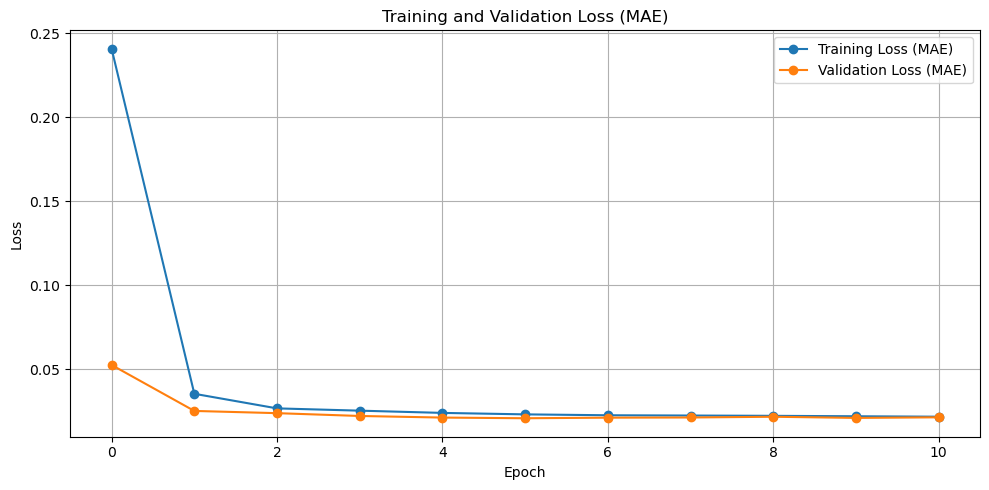

In [73]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Training Loss (MAE)', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss (MAE)', marker='o')
plt.title('Training and Validation Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

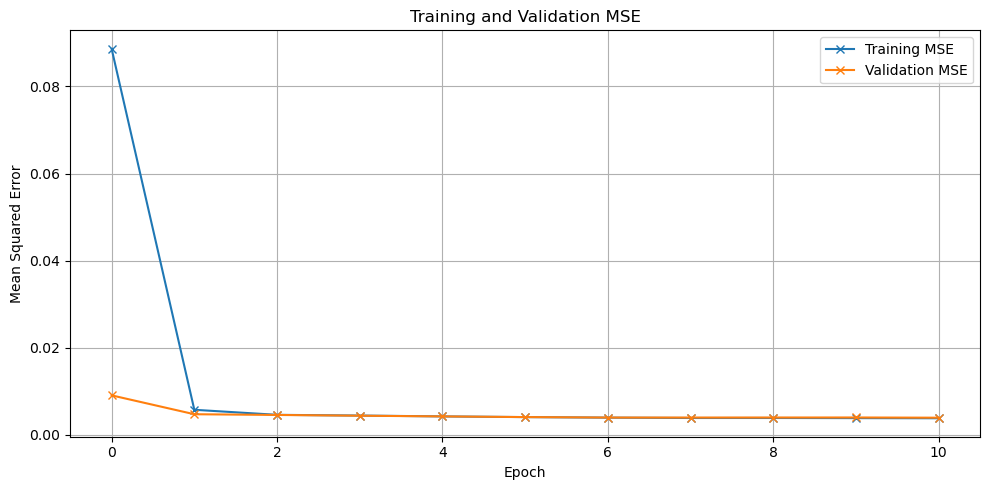

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(history_dict['mse'], label='Training MSE', marker='x')
plt.plot(history_dict['val_mse'], label='Validation MSE', marker='x')
plt.title('Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Remarks:

1. Loss (MAE) plot:
- Large initial decline in the first 3-5 epochs → the model quickly learns to reconstruct benign data.
- From epoch ~10 onwards, the curve stabilizes.
- No signs of overfitting:

The model is generalizing well, and that training was sufficient with no need for further training.

2. MSE graph
- very similar to MAE:
- No abnormal peaks or fluctuations, confirming that the model is stable.

The val_mse curve follows mse closely, reinforcing that there is no overfitting and the model is ready to evaluate in test.

The autoencoder has correctly learned to reconstruct benign data.

### Calculate the reconstruction error on X_test_scaled

If the PDF is benign, the model should reconstruct it very well (low error).

If the PDF is malicious, its structure will not be “familiar” → the autoencoder will fail to reconstruct → high error.

In [75]:
X_test_pred = autoencoder.predict(X_test_scaled)

reconstruction_error = np.mean(np.abs(X_test_pred - X_test_scaled), axis=1)

print(pd.Series(reconstruction_error).describe())

201/201 [==============================] - 1s 2ms/step
count    6414.000000
mean        0.047162
std         0.258011
min         0.003236
25%         0.015277
50%         0.019862
75%         0.035378
max        11.534980
dtype: float64


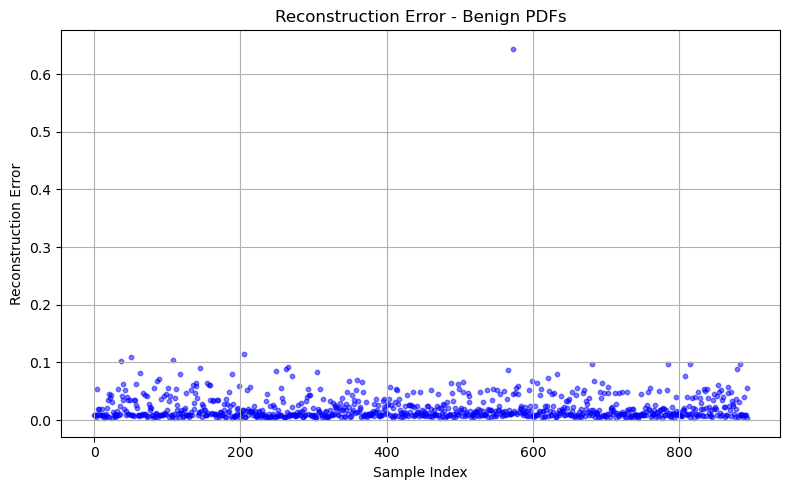

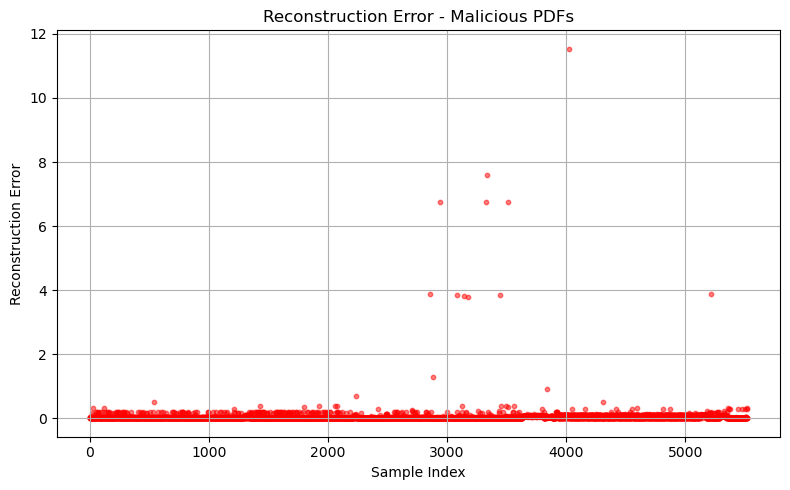

In [76]:
df_error = pd.DataFrame({
    'Reconstruction Error': reconstruction_error,
    'Label': y_test
})

benign_errors = df_error[df_error['Label'] == 'Benign']['Reconstruction Error']
malicious_errors = df_error[df_error['Label'] == 'Malicious']['Reconstruction Error']

# BENIGN PDFS
plt.figure(figsize=(8, 5))
plt.scatter(range(len(benign_errors)), benign_errors, color='blue', alpha=0.5, s=10)
plt.title("Reconstruction Error - Benign PDFs")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# MALICIOUS PDFS
plt.figure(figsize=(8, 5))
plt.scatter(range(len(malicious_errors)), malicious_errors, color='red', alpha=0.5, s=10)
plt.title("Reconstruction Error - Malicious PDFs")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.grid(True)
plt.tight_layout()
plt.show()



## Threshold and predictions

In [80]:
y_test_bin = y_test.map({'Benign': 0, 'Malicious': 1}).values

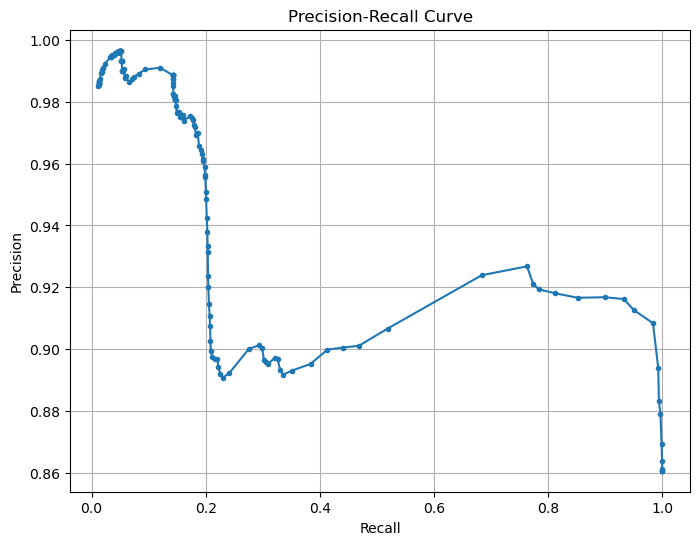

In [ ]:
thresholds = np.linspace(0.001, 0.2, 200)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (reconstruction_error > t).astype(int)
    precisions.append(precision_score(y_test_bin, y_pred))
    recalls.append(recall_score(y_test_bin, y_pred))
    f1s.append(f1_score(y_test_bin, y_pred))

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_f1 = f1s[best_idx]

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

<Figure size 600x500 with 0 Axes>

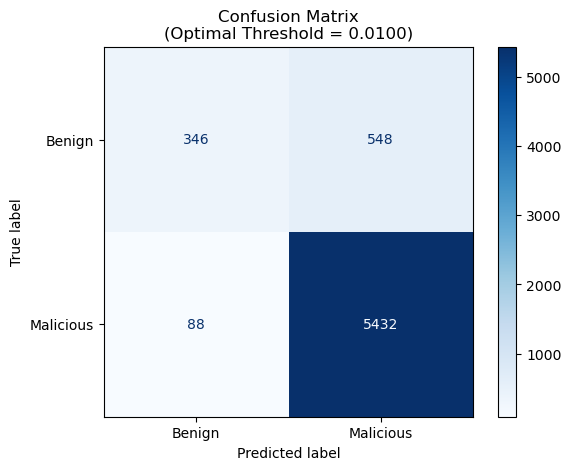

Threshold óptimo: 0.0100
Precision: 0.9084
Recall:    0.9841
F1-score:  0.9447


In [ ]:
y_pred_optimal = (reconstruction_error > best_threshold).astype(int)

cm = confusion_matrix(y_test_bin, y_pred_optimal)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malicious"])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix\n(Optimal Threshold = {best_threshold:.4f})')
plt.grid(False)
plt.show()

print(f"Threshold óptimo: {best_threshold:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall:    {best_recall:.4f}")
print(f"F1-score:  {best_f1:.4f}")
